In [228]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import time
import math
import numpy as np
import datetime as dt
from datetime import date, datetime, timedelta

import seaborn as sns

datetime.datetime(2014, 12, 31, 0, 0)

In [9]:
#functions
def stddev_series(column,period):
    sdev_series=[0.0]*(period)
    for i in range(period,len(column)):
        sdev = column[i-period:i].std()
        sdev_series.append(sdev)
    return(sdev_series)

In [166]:
## create dictionaries of normalized telemetry data and failures data for each machineID

failures_df = pd.read_csv('PdM_failures2.csv',index_col=0)
telemetry_df_days = pd.read_csv('processed_telemetry.csv',index_col=0)

for i in range(len(failures_df['failure'])):
    entry = str(failures_df['failure'][i])[-1]
    failures_df['failure'][i] = int(entry)

for i in range(len(failures_df['model'])):
    entry = str(failures_df['model'][i])[-1]
    failures_df['model'][i] = int(entry)

telemetry_df_days_scale = telemetry_df_days.copy()
for i in range(len(telemetry_df_days)):
    telemetry_df_days_scale['volt'][i] = telemetry_df_days['volt'][i]/telemetry_df_days['volt'].max()
    telemetry_df_days_scale['rotate'][i] = telemetry_df_days['rotate'][i]/telemetry_df_days['rotate'].max()
    telemetry_df_days_scale['pressure'][i] = telemetry_df_days['pressure'][i]/telemetry_df_days['pressure'].max()
    telemetry_df_days_scale['vibration'][i] = telemetry_df_days['vibration'][i]/telemetry_df_days['vibration'].max()
#telemetry_df_days_scale.to_csv('processed_telemetry_scaled.csv')

measurements = ['volt', 'rotate', 'pressure', 'vibration']

## calculate 5
n_per = 5
IDs = list(telemetry_df_days_scale['machineID'].unique())

telemetry_df_dict = {}
for id in IDs:
    telemetry_df_dict[id] = telemetry_df_days_scale[telemetry_df_days_scale['machineID']==id].reset_index(drop=True)    
        
failures_df_dict = {}
for id in IDs:
    failures_df_dict[id] = failures_df[failures_df['machineID']==id].reset_index(drop=True)

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [167]:
# calculate rolling std dev of past 5 days
for id in IDs:
    for measurement in measurements:
        telemetry_df_dict[id][measurement + ' sdev '+str(n_per)] = stddev_series(telemetry_df_dict[id][measurement],n_per)
        
# label if a day had a failure (1) or no failure(0)
for id in IDs:
    telemetry_df_dict[id]['fail'] = [0]*len(telemetry_df_dict[id])
    for date1 in telemetry_df_dict[id]['date']:
        for date2 in failures_df_dict[id]['date']:
            if date1==date2:
                index = telemetry_df_dict[id][telemetry_df_dict[id]['date']==date1].index
                telemetry_df_dict[id]['fail'][index]=1


c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [169]:
machines_df=pd.read_csv('PdM_machines.csv')
maint_df=pd.read_csv('PdM_maint.csv')

for i in range(len(machines_df)):
    machines_df['model'][i] = int(str(machines_df['model'][i])[-1])

for i in range(len(df)):
    df['machineID'][i] = int(df['machineID'][i])

In [197]:
def str2date(input_str):
    try:
        day = int(input_str[0:2])
        month = int(input_str[3:5])
        year = int(input_str[6:10])
        datee = date(year, month, day)
        return(datee)
    except:
        pass 
    
maint_df['date'] = [0]*len(maint_df)
for i in range(len(maint_df)):
    maint_df['date'][i] = str2date(maint_df['datetime'][i])
    
maint_df_dict = {}
for id in IDs:
    maint_df_dict[id] = maint_df[maint_df['machineID']==id].reset_index(drop=True)

In [285]:


df = telemetry_df_dict[1].copy()

df['days_last_maint']=[0]*len(df)
df['days_last_fail'] = [0]*len(df)
index = df['machineID'][0]-1
df['model'] = machines_df['model'][index]

df2 = maint_df_dict[1]
for i in range(len(df2)):
    df2['day_num'][i] = (df2['date'][i] - dt.date(2015,1,1)).days
    
#days last maint
for i in range(len(df)):
    sample_date = df['day_num'][i]
    day_of_maint = df2[df2['day_num']<sample_date]['day_num'].max()
    df['days_last_maint'][i] = df['day_num'][i] - day_of_maint-1
    if df['fail'][i]==1:
        df['days_last_maint'][i]=df['days_last_maint'][i-1]+1

#days since last failure
for i in range(1,len(df)):
    if df['fail'][i-1]==0:
        df['days_last_fail'][i] = df['days_last_fail'][i-1]+1
    else:
        df['days_last_fail'][i]=0

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [298]:
for id in IDs:
    
    telemetry_df_dict[id]['days_last_maint']=[0]*len(telemetry_df_dict[id])
    telemetry_df_dict[id]['days_last_fail'] = [0]*len(telemetry_df_dict[id])
    index = telemetry_df_dict[id]['machineID'][0]-1
    telemetry_df_dict[id]['model'] = machines_df['model'][index]

    maint_df_dict[id]['day_num'] = [0]*len(maint_df_dict[id])
    for i in range(len(maint_df_dict[id])):
        
        maint_df_dict[id]['day_num'][i] = (maint_df_dict[id]['date'][i] - dt.date(2015,1,1)).days

    #days last maint
    for i in range(len(telemetry_df_dict[id])):
        sample_date = telemetry_df_dict[id]['day_num'][i]
        day_of_maint = maint_df_dict[id][maint_df_dict[id]['day_num']<sample_date]['day_num'].max()
        telemetry_df_dict[id]['days_last_maint'][i] = telemetry_df_dict[id]['day_num'][i] - day_of_maint-1
        if telemetry_df_dict[id]['fail'][i]==1:
            telemetry_df_dict[id]['days_last_maint'][i]=telemetry_df_dict[id]['days_last_maint'][i-1]+1

    #days since last failure
    for i in range(1,len(telemetry_df_dict[id])):
        if telemetry_df_dict[id]['fail'][i-1]==0:
            telemetry_df_dict[id]['days_last_fail'][i] = telemetry_df_dict[id]['days_last_fail'][i-1]+1
        else:
            telemetry_df_dict[id]['days_last_fail'][i]=0

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [299]:
telemetry_df_dict[1]

,day_num,date,machineID,volt,rotate,pressure,vibration,volt sdev 5,rotate sdev 5,pressure sdev 5,vibration sdev 5,fail,days_last_maint,days_last_fail,model
0,1,2015-01-01,1.0,0.778868,0.907848,0.635519,0.653450,0.000000,0.000000,0.000000,0.000000,0,19,0,3
1,2,2015-01-02,1.0,0.773930,0.924974,0.656522,0.648729,0.000000,0.000000,0.000000,0.000000,0,20,1,3
2,3,2015-01-03,1.0,0.785385,0.916093,0.658057,0.857631,0.000000,0.000000,0.000000,0.000000,0,21,2,3
3,4,2015-01-04,1.0,0.784867,0.901917,0.647500,0.851501,0.000000,0.000000,0.000000,0.000000,0,22,3,3
4,5,2015-01-05,1.0,0.783207,0.947316,0.680531,0.647902,0.000000,0.000000,0.000000,0.000000,1,23,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,361,2015-12-27,1.0,0.786717,0.908787,0.673275,0.623090,0.019539,0.022030,0.015014,0.015296,0,11,10,3
361,362,2015-12-28,1.0,0.751773,0.896173,0.654776,0.664352,0.019206,0.019768,0.017454,0.023461,0,12,11,3
362,363,2015-12-29,1.0,0.753355,0.924974,0.639607,0.643951,0.021144,0.019374,0.017261,0.023752,0,13,12,3
363,364,2015-12-30,1.0,0.774536,0.923247,0.650486,0.656753,0.022617,0.018316,0.018433,0.024150,0,14,13,3


In [296]:

for i in range(len(telemetry_df_dict[id])):
    sample_date = telemetry_df_dict[id]['day_num'][i]
    day_of_maint = maint_df_dict[id][maint_df_dict[id]['day_num']<sample_date]['day_num'].max()
    df['days_last_maint'][i] = df['day_num'][i] - day_of_maint-1
    if df['fail'][i]==1:
        df['days_last_maint'][i]=df['days_last_maint'][i-1]+1

,datetime,machineID,comp,date,day_num
0,16/06/2014 06:00,3,comp3,2014-06-16,-199
1,01/07/2014 06:00,3,comp4,2014-07-01,-184
2,15/08/2014 06:00,3,comp1,2014-08-15,-139
3,28/11/2014 06:00,3,comp2,2014-11-28,-34
4,07/01/2015 06:00,3,comp2,2015-01-07,6
5,22/01/2015 06:00,3,comp4,2015-01-22,21
6,06/02/2015 06:00,3,comp1,2015-02-06,36
7,21/02/2015 06:00,3,comp1,2015-02-21,51
8,21/02/2015 06:00,3,comp3,2015-02-21,51
9,08/03/2015 06:00,3,comp3,2015-03-08,66


In [284]:
df.head(6)

,day_num,date,machineID,volt,rotate,pressure,vibration,volt sdev 5,rotate sdev 5,pressure sdev 5,vibration sdev 5,fail,days_last_maint,days_last_fail,model
0,1,2015-01-01,1.0,0.778868,0.907848,0.635519,0.653450,0.000000,0.000000,0.000000,0.000000,0,19,0,3
1,2,2015-01-02,1.0,0.773930,0.924974,0.656522,0.648729,0.000000,0.000000,0.000000,0.000000,0,20,1,3
2,3,2015-01-03,1.0,0.785385,0.916093,0.658057,0.857631,0.000000,0.000000,0.000000,0.000000,0,21,2,3
3,4,2015-01-04,1.0,0.784867,0.901917,0.647500,0.851501,0.000000,0.000000,0.000000,0.000000,0,22,3,3
4,5,2015-01-05,1.0,0.783207,0.947316,0.680531,0.647902,0.000000,0.000000,0.000000,0.000000,1,23,4,3
5,6,2015-01-06,1.0,0.783480,0.898513,0.662758,0.689311,0.004829,0.017749,0.016563,0.112072,0,1,0,3


In [268]:
failures_df

,datetime,machineID,failure,date,days_last_maint,age,model
0,05/01/2015 06:00,1,4,2015-01-05,173,18,3
1,06/03/2015 06:00,1,1,2015-03-06,45,18,3
2,20/04/2015 06:00,1,2,2015-04-20,323,18,3
3,19/06/2015 06:00,1,4,2015-06-19,135,18,3
4,02/09/2015 06:00,1,4,2015-09-02,75,18,3
...,...,...,...,...,...,...,...
756,29/11/2015 06:00,99,3,2015-11-29,60,14,1
757,14/12/2015 06:00,99,4,2015-12-14,45,14,1
758,12/02/2015 06:00,100,1,2015-02-12,151,5,4
759,10/09/2015 06:00,100,1,2015-09-10,45,5,4


In [ ]:
#label each failure by component 1= comp1, 2=comp2, ect, this labelled dict is telemetry_df_dict1
telemetry_df_dict1= telemetry_df_dict.copy()
for id in IDs:
    telemetry_df_dict1[id]['fail'] = [0]*len(telemetry_df_dict[id])
    for date1 in telemetry_df_dict1[id]['date']:
        for date2 in failures_df_dict[id]['date']:
            if date1==date2:
                index1 = telemetry_df_dict1[id][telemetry_df_dict1[id]['date']==date1].index.values.astype(int)[0]
                index2 = failures_df_dict[id][failures_df_dict[id]['date']==date2].index.values.astype(int)[0]
                telemetry_df_dict1[id]['fail'][index1]=failures_df_dict[id]['failure'][index2]

In [297]:
#calculate average 5day stdev for all measurements for: all days, only days without failure, only days with failure
sum_sdev_all = []
sum_sdev_nofail = []
sum_sdev_fail = []

measurements = ['volt', 'rotate', 'pressure', 'vibration']

for measurement in measurements:
    for id in IDs:
        sum_sdev_all.append(telemetry_df_dict[id][5:][measurement +' sdev 5'].mean())
        sum_sdev_nofail.append(telemetry_df_dict[id][5:][telemetry_df_dict[id][5:]['fail']==0][measurement +' sdev 5'].mean())
        sum_sdev_fail.append(telemetry_df_dict[id][5:][telemetry_df_dict[id][5:]['fail']==1][measurement + ' sdev 5'].mean())
        sum_sdev_fail = [0 if math.isnan(x) else x for x in sum_sdev_fail]
    
    print(measurement + ' sum_sdev_all: ' +str(np.mean(sum_sdev_all)))
    print(measurement + ' sum_sdev_nofail: ' +str(np.mean(sum_sdev_nofail)))
    print(measurement + ' sum_sdev_fail: ' +str(np.mean(sum_sdev_fail)))
    print('\n')

volt sum_sdev_all: 0.016637060778533063
volt sum_sdev_nofail: 0.016464265057376384
volt sum_sdev_fail: 0.026434945964707676


rotate sum_sdev_all: 0.021680273644093185
rotate sum_sdev_nofail: 0.021382212235426818
rotate sum_sdev_fail: 0.03823562405263391


pressure sum_sdev_all: 0.02081904246348814
pressure sum_sdev_nofail: 0.020544763935115964
pressure sum_sdev_fail: 0.034834149077145646


vibration sum_sdev_all: 0.021281677091704115
vibration sum_sdev_nofail: 0.021001386913125645
vibration sum_sdev_fail: 0.034927683757892




#on average the standard deviation of each measurement is greater in the 5 days before failure, than in other 5 day periods without failure

In [14]:
failures_df['age'].describe()

count    761.000000
mean      12.608410
std        5.669088
min        0.000000
25%        9.000000
50%       14.000000
75%       17.000000
max       20.000000
Name: age, dtype: float64

In [382]:
failures_df['days_last_maint'].describe()

count    761.000000
mean      88.879106
std       60.964171
min        1.000000
25%       45.000000
50%       67.000000
75%      118.000000
max      395.000000
Name: days_last_maint, dtype: float64

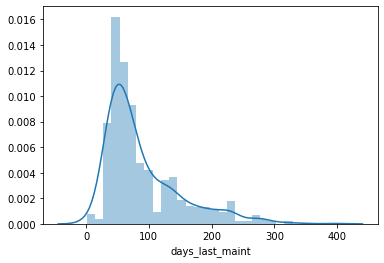

In [105]:
sns.distplot(failures_df['days_last_maint'], kde = True, bins=30)

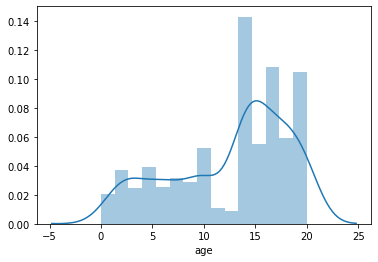

In [107]:
sns.distplot(failures_df['age'],kde=True, bins = 15)

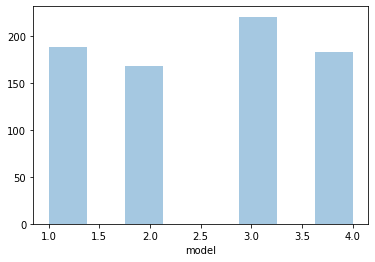

In [48]:
sns.distplot(failures_df['model'],kde=False, bins=8)

In [64]:
machines_df=pd.read_csv('PdM_machines.csv')
for i in range(len(machines_df['model'])):
    entry = str(machines_df['model'][i])[-1]
    machines_df['model'][i] = int(entry)

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [86]:
#calculate failures per model = failures in model / number of machines in that model

models = list(failures_df['model'].unique())
for model in models:
    print('model ' + str(model) + ' avg age is ' +str(failures_df[failures_df['model']==model]['age'].mean()))
    print('model ' + str(model) + ' number failures is ' +str(len(failures_df[failures_df['model']==model]['age'])))
    num_machines = machines_df['model'].value_counts()[model]
    num_failures = len(failures_df[failures_df['model']==model]['age']) 
    print('model ' + str(model) + ' number machines is ' + str(num_machines) )
    print('model ' + str(model) + ' number failures/machine in model is ' + str(num_failures/num_machines)[0:5] )

    print('\n')

model 3 avg age is 13.004524886877828
model 3 number failures is 221
model 3 number machines is 35
model 3 number failures/machine in model is 6.314


model 4 avg age is 11.202185792349727
model 4 number failures is 183
model 4 number machines is 32
model 4 number failures/machine in model is 5.718


model 2 avg age is 13.523809523809524
model 2 number failures is 168
model 2 number machines is 17
model 2 number failures/machine in model is 9.882


model 1 avg age is 12.693121693121693
model 1 number failures is 189
model 1 number machines is 16
model 1 number failures/machine in model is 11.81




In [84]:
#create new column for days since last failure (machine)
failures_df

,datetime,machineID,failure,date,days_last_maint,age,model
0,05/01/2015 06:00,1,4,2015-01-05,173,18,3
1,06/03/2015 06:00,1,1,2015-03-06,45,18,3
2,20/04/2015 06:00,1,2,2015-04-20,323,18,3
3,19/06/2015 06:00,1,4,2015-06-19,135,18,3
4,02/09/2015 06:00,1,4,2015-09-02,75,18,3
...,...,...,...,...,...,...,...
756,29/11/2015 06:00,99,3,2015-11-29,60,14,1
757,14/12/2015 06:00,99,4,2015-12-14,45,14,1
758,12/02/2015 06:00,100,1,2015-02-12,151,5,4
759,10/09/2015 06:00,100,1,2015-09-10,45,5,4


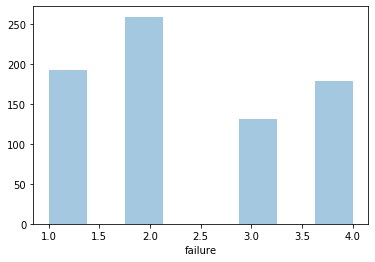

In [99]:
sns.distplot(failures_df['failure'],kde=False, bins=8)

In [114]:
telemetry_df_dict[1].head()

,day_num,date,machineID,volt,rotate,pressure,vibration,volt sdev 5,rotate sdev 5,pressure sdev 5,vibration sdev 5,fail
0,1,2015-01-01,1.0,0.778868,0.907848,0.635519,0.653450,0.0,0.0,0.0,0.0,0
1,2,2015-01-02,1.0,0.773930,0.924974,0.656522,0.648729,0.0,0.0,0.0,0.0,0
2,3,2015-01-03,1.0,0.785385,0.916093,0.658057,0.857631,0.0,0.0,0.0,0.0,0
3,4,2015-01-04,1.0,0.784867,0.901917,0.647500,0.851501,0.0,0.0,0.0,0.0,0
4,5,2015-01-05,1.0,0.783207,0.947316,0.680531,0.647902,0.0,0.0,0.0,0.0,4


In [159]:
new_telemetry_df

,day_num,date,machineID,volt,rotate,pressure,vibration,volt sdev 5,rotate sdev 5,pressure sdev 5,vibration sdev 5,fail
0,1,2015-01-01,1.0,0.778868,0.907848,0.635519,0.653450,0.000000,0.000000,0.000000,0.000000,0
1,2,2015-01-02,1.0,0.773930,0.924974,0.656522,0.648729,0.000000,0.000000,0.000000,0.000000,0
2,3,2015-01-03,1.0,0.785385,0.916093,0.658057,0.857631,0.000000,0.000000,0.000000,0.000000,0
3,4,2015-01-04,1.0,0.784867,0.901917,0.647500,0.851501,0.000000,0.000000,0.000000,0.000000,0
4,5,2015-01-05,1.0,0.783207,0.947316,0.680531,0.647902,0.000000,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
36495,361,2015-12-27,100.0,0.788497,0.900757,0.645044,0.653438,0.010763,0.014040,0.010889,0.006481,0
36496,362,2015-12-28,100.0,0.776419,0.946923,0.655262,0.649552,0.013633,0.015800,0.010711,0.003788,0
36497,363,2015-12-29,100.0,0.759835,0.920683,0.621358,0.672482,0.008599,0.021484,0.009563,0.004623,0
36498,364,2015-12-30,100.0,0.761920,0.936885,0.666915,0.647039,0.010916,0.019054,0.016397,0.008848,0


In [161]:
failures_df

,datetime,machineID,failure,date,days_last_maint,age,model
0,05/01/2015 06:00,1,4,2015-01-05,173,18,3
1,06/03/2015 06:00,1,1,2015-03-06,45,18,3
2,20/04/2015 06:00,1,2,2015-04-20,323,18,3
3,19/06/2015 06:00,1,4,2015-06-19,135,18,3
4,02/09/2015 06:00,1,4,2015-09-02,75,18,3
...,...,...,...,...,...,...,...
756,29/11/2015 06:00,99,3,2015-11-29,60,14,1
757,14/12/2015 06:00,99,4,2015-12-14,45,14,1
758,12/02/2015 06:00,100,1,2015-02-12,151,5,4
759,10/09/2015 06:00,100,1,2015-09-10,45,5,4


In [ ]:
#merge failures df with telemetry_df
#features:


In [165]:
telemetry_df_dict[1]

,day_num,date,machineID,volt,rotate,pressure,vibration,volt sdev 5,rotate sdev 5,pressure sdev 5,vibration sdev 5,fail
0,1,2015-01-01,1.0,0.778868,0.907848,0.635519,0.653450,0.000000,0.000000,0.000000,0.000000,0
1,2,2015-01-02,1.0,0.773930,0.924974,0.656522,0.648729,0.000000,0.000000,0.000000,0.000000,0
2,3,2015-01-03,1.0,0.785385,0.916093,0.658057,0.857631,0.000000,0.000000,0.000000,0.000000,0
3,4,2015-01-04,1.0,0.784867,0.901917,0.647500,0.851501,0.000000,0.000000,0.000000,0.000000,0
4,5,2015-01-05,1.0,0.783207,0.947316,0.680531,0.647902,0.000000,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
360,361,2015-12-27,1.0,0.786717,0.908787,0.673275,0.623090,0.019539,0.022030,0.015014,0.015296,0
361,362,2015-12-28,1.0,0.751773,0.896173,0.654776,0.664352,0.019206,0.019768,0.017454,0.023461,0
362,363,2015-12-29,1.0,0.753355,0.924974,0.639607,0.643951,0.021144,0.019374,0.017261,0.023752,0
363,364,2015-12-30,1.0,0.774536,0.923247,0.650486,0.656753,0.022617,0.018316,0.018433,0.024150,0


In [300]:
new_telemetry_df = telemetry_df_dict[1].copy()
for id in IDs[1:]:
    new_telemetry_df = new_telemetry_df.append(telemetry_df_dict[id])
new_telemetry_df = new_telemetry_df.reset_index(drop=True)

In [308]:
for i in range(len(new_telemetry_df)):
    new_telemetry_df['machineID'][i] = int(new_telemetry_df['machineID'][i])

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [311]:
new_telemetry_df.to_csv('input_df_2020-08-09-1936.csv')
